In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from scipy import spatial

In [2]:
# Stopwords in french (no information)
stopwords_fr = []
with open("data/stopwords/stopwords-fr.txt", 'r', encoding='utf-8') as f:
    stopwords_fr = f.readlines()
    stopwords_fr = [w.strip() for w in stopwords_fr]
stopwords_fr[:10]

['a', 'à', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies']

In [3]:
stopwords_fr.remove('o|')

In [4]:
# punctations in french (no information)
punctuations_fr = "\"$%&'?!()*+,-./:;=@[\]^_`{|}'~«»´’–"

In [5]:
# Load all the tweets
party_tweets = pd.read_csv("data/twitter_data/party_tweets.csv")
member_tweets = pd.read_csv("data/twitter_data/merged_member_tweets.csv")

In [6]:
# Adding a new column called year and which contains the year of the tweets
def extract_year(tweets):
    tweets_copy = tweets.copy()
    tweets_copy['year'] = tweets_copy['timestamp'].str[-4:].astype(int)  
    return tweets_copy

In [7]:
# Add the years of the tweets
party_tweets = extract_year(party_tweets)
member_tweets = extract_year(member_tweets)

In [8]:
# Change name of a column to be coherent
party_tweets = party_tweets.rename(columns={'partyname': 'party_name'})

In [9]:
party_tweets.head()

,id,timestamp,party_name,username,tweet_text,all_hashtags,all_mentions,all_urls,retweet_count,favorite_count,range,lang,year
0,1196812925580840961,Tue Nov 19 15:30:11 +0000 2019,UDC Suisse,UDCch,"Durant la session d’hiver à venir, le Parlemen...",[],[],['https://www.udc.ch/actualites/articles/commu...,0,5,259,fr,2019
1,1196375024124538880,Mon Nov 18 10:30:07 +0000 2019,UDC Suisse,UDCch,"Le glissement à gauche, qui a eu lieu lors des...",[],[],['https://www.udc.ch/actualites/articles/commu...,1,9,218,fr,2019
2,1189851774510874624,Thu Oct 31 10:29:04 +0000 2019,UDC Suisse,UDCch,"Au lieu d'attaquer le mal à la racine, le Cons...",[],[],['https://www.udc.ch/actualites/articles/commu...,2,7,145,fr,2019
3,1187013387508748288,Wed Oct 23 14:30:19 +0000 2019,UDC Suisse,UDCch,Les conséquences nuisibles de l’immigration dé...,[],[],['https://www.udc.ch/actualites/articles/commu...,3,17,208,fr,2019
4,1186266665358647298,Mon Oct 21 13:03:07 +0000 2019,UDC Suisse,UDCch,«Un tout grand Merci à toutes les électrices e...,[],[],[],7,28,272,fr,2019


In [10]:
member_tweets.head()

,id,timestamp,member_name,party_name,username,tweet_text,all_hashtags,all_mentions,all_urls,retweet_count,favorite_count,range,lang,year
0,1196747623471996928,Tue Nov 19 11:10:42 +0000 2019,Christian Levrat,PS Suisse,ChristianLevrat,@patoudoux @nantermod Heureux pays... petits s...,[],"['patoudoux', 'nantermod']",[],0,5,56,fr,2019
1,1196741312264970240,Tue Nov 19 10:45:37 +0000 2019,Christian Levrat,PS Suisse,ChristianLevrat,"RT @MikeMuellerLate: Liebe @claudia_blumer, ge...",[],"['MikeMuellerLate', 'claudia_blumer', 'tagesan...",[],27,0,140,de,2019
2,1196064766248280066,Sun Nov 17 13:57:16 +0000 2019,Christian Levrat,PS Suisse,ChristianLevrat,"Des résultats convaincants, voire époustouflan...",[],"['MarinaCarobbio', 'zanettiroberto', 'PaulRech...",[],13,98,159,fr,2019
3,1193533989333749760,Sun Nov 10 14:20:52 +0000 2019,Christian Levrat,PS Suisse,ChristianLevrat,Alors qu’on attend toujours les résultats (ent...,[],[],[],16,89,106,fr,2019
4,1193083434790531073,Sat Nov 09 08:30:31 +0000 2019,Christian Levrat,PS Suisse,ChristianLevrat,"Merci d’y penser, de faire un effort et de pas...",[],[],[],7,41,194,fr,2019


In [11]:
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'SVP Schweiz', 'SP Schweiz', 'FDP Schweiz',
       'GRÜNE Schweiz 🌻', 'Grünliberale Schweiz', 'CVP PDC PPD PCD'],
      dtype=object)

In [12]:
# Replace the german names of the parties by the french ones 
party_tweets.loc[(party_tweets.party_name == 'SVP Schweiz'), 'party_name'] = 'UDC Suisse'
party_tweets.loc[(party_tweets.party_name == 'SP Schweiz'), 'party_name'] = 'PS Suisse'
party_tweets.loc[(party_tweets.party_name == 'FDP Schweiz'), 'party_name'] = 'PLR Suisse'
party_tweets.loc[(party_tweets.party_name == 'GRÜNE Schweiz 🌻'), 'party_name'] = 'Les VERTS suisses 🌻'
party_tweets.loc[(party_tweets.party_name == 'Grünliberale Schweiz'), 'party_name'] = "Vert'libéraux Suisse"
party_tweets['party_name'].unique()

array(['UDC Suisse', 'PS Suisse', 'PLR Suisse', 'Les VERTS suisses 🌻',
       "Vert'libéraux Suisse", 'CVP PDC PPD PCD'], dtype=object)

In [13]:
member_tweets['party_name'].unique()

array(['PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'],
      dtype=object)

In [14]:
# Group all the tweets (member + party) in one dataframe 
tweets = pd.concat([party_tweets, member_tweets], sort=True)
tweets

,all_hashtags,all_mentions,all_urls,favorite_count,id,lang,member_name,party_name,range,retweet_count,timestamp,tweet_text,username,year
0,[],[],['https://www.udc.ch/actualites/articles/commu...,5,1196812925580840961,fr,NaN,UDC Suisse,259,0,Tue Nov 19 15:30:11 +0000 2019,"Durant la session d’hiver à venir, le Parlemen...",UDCch,2019
1,[],[],['https://www.udc.ch/actualites/articles/commu...,9,1196375024124538880,fr,NaN,UDC Suisse,218,1,Mon Nov 18 10:30:07 +0000 2019,"Le glissement à gauche, qui a eu lieu lors des...",UDCch,2019
2,[],[],['https://www.udc.ch/actualites/articles/commu...,7,1189851774510874624,fr,NaN,UDC Suisse,145,2,Thu Oct 31 10:29:04 +0000 2019,"Au lieu d'attaquer le mal à la racine, le Cons...",UDCch,2019
3,[],[],['https://www.udc.ch/actualites/articles/commu...,17,1187013387508748288,fr,NaN,UDC Suisse,208,3,Wed Oct 23 14:30:19 +0000 2019,Les conséquences nuisibles de l’immigration dé...,UDCch,2019
4,[],[],[],28,1186266665358647298,fr,NaN,UDC Suisse,272,7,Mon Oct 21 13:03:07 +0000 2019,«Un tout grand Merci à toutes les électrices e...,UDCch,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132835,['Ecopop'],[],[],31,535102663692914689,de,Ruedi Noser,PLR Suisse,103,21,Wed Nov 19 16:09:51 +0000 2014,Auch wenn wir uns in der 30% Marke befinden – ...,RuediNoser,2014
132836,['Swissness'],"['silvan_z', 'AargauerZeitung']",['http://ow.ly/Ew1k8'],1,535016276029374464,de,Ruedi Noser,PLR Suisse,82,0,Wed Nov 19 10:26:34 +0000 2014,Verordnungsstress um #Swissness. @silvan_z @Aa...,RuediNoser,2014
132837,['Innovationspark'],"['BaSchaffner', 'RuediNoser', 'NZZ']",[],0,534340108951244800,de,Ruedi Noser,PLR Suisse,140,1,Mon Nov 17 13:39:44 +0000 2014,RT @BaSchaffner: @RuediNoser @NZZ Deshalb JA z...,RuediNoser,2014
132838,['Innovationspark'],['NZZ'],['http://ow.ly/i/7BDgb'],1,534259720618381312,de,Ruedi Noser,PLR Suisse,96,1,Mon Nov 17 08:20:18 +0000 2014,Wie der #Innovationspark Schweiz private Inves...,RuediNoser,2014


In [15]:
print("Years of activity for each party: ")
years_UDC = party_tweets[party_tweets.party_name=='UDC Suisse']['year'].unique()
print("UDC: %s" % years_UDC)
years_PS = party_tweets[party_tweets.party_name=='PS Suisse']['year'].unique()
print("PS: %s" % years_PS)
years_PLR = party_tweets[party_tweets.party_name=='PLR Suisse']['year'].unique()
print("PLR: %s" % years_PLR)
years_VERTS = party_tweets[party_tweets.party_name=='Les VERTS suisses 🌻']['year'].unique()
print("VERTS: %s" % years_VERTS)
years_VERTS_LIB = party_tweets[party_tweets.party_name=="Vert'libéraux Suisse"]['year'].unique()
print("VERTS LIB: %s" % years_VERTS_LIB)
years_PDC = party_tweets[party_tweets.party_name=='CVP PDC PPD PCD']['year'].unique()
print("PDC: %s" % years_PDC)

Years of activity for each party: 
UDC: [2019 2018 2017 2016 2015 2014 2013]
PS: [2019 2018 2017 2016 2015 2014 2013 2012 2011]
PLR: [2019 2018 2017 2016 2015]
VERTS: [2019 2018 2017 2016 2015 2014 2013 2012 2011 2010]
VERTS LIB: [2019 2018 2017 2016 2015 2014 2012 2011 2010]
PDC: [2019 2018 2017]


# Keywords of parties

In [16]:
from collections import Counter

YEARS = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]

def tweets_to_text(tweets, lang, party_name, year=YEARS):
    """
    Returns a text of all the tweets of a party after processing them.
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    """
    tweets_copy = tweets.copy()
    tweets_copy = tweets_copy[tweets_copy.lang==lang]
    tweets_copy = tweets_copy[tweets_copy.party_name==party_name]
    tweets_copy = tweets_copy[tweets_copy['year'].isin(year)]
    tweets_copy = tweets_copy["tweet_text"].str.lower()
    
    text = ""
    for t in tweets_copy:
        text += ' ' +  t
    
    text = re.sub(r'https:\/\/t\.co\/.{10}', '', text)
    text = re.sub(r'http:\/\/t\.co\/.{10}', '', text)
    
    if (lang=='fr'):
        for c in punctuations_fr:
            text = text.replace(c, ' ')
        for w in stopwords_fr:
            regex = r" " + w + " "
            text = re.sub(regex, ' ', text)
        text = text.replace('  ', ' ')
        text = text.replace('  ', ' ')
        text = text.replace('  ', ' ')
        
        return text
    else:
        raise NotImplementedError # TODO    

def text_to_bag(text):
    """
    Return a bag of word sorted by frequency given a text
    """
    return Counter(text.split(" ")).most_common()


In [17]:
# Generating the text for all parties:
VERTS_text = tweets_to_text(tweets, lang='fr', party_name='Les VERTS suisses 🌻')
UDC_text = tweets_to_text(tweets, lang='fr', party_name='UDC Suisse')
PLR_text = tweets_to_text(tweets, lang='fr', party_name='PLR Suisse')
PDC_text = tweets_to_text(tweets, lang='fr', party_name='CVP PDC PPD PCD')
PS_text = tweets_to_text(tweets, lang='fr', party_name='PS Suisse')
VERTS_LIB_text = tweets_to_text(tweets, lang='fr', party_name="Vert'libéraux Suisse")

In [18]:
VERTS_bag = text_to_bag(VERTS_text)
VERTS_bag

[('verts', 920),
 ('adelethorens', 592),
 ('conseil', 534),
 ('suisse', 534),
 ('lesvertssuisses', 505),
 ('initiative', 451),
 ('climat', 447),
 ('vertsvd', 438),
 ('\u2066', 400),
 ('fédéral', 262),
 ('oui', 258),
 ('…', 252),
 ('lesvertssuisse', 243),
 ('politique', 239),
 ('#climat', 237),
 ('amp', 227),
 ('parlement', 225),
 ('#vertsad', 202),
 ('national', 193),
 ('climatique', 183),
 ('protection', 176),
 ('loi', 175),
 ('ge', 155),
 ('environnement', 152),
 ('2', 149),
 ('etats', 147),
 ('femmes', 144),
 ('économie', 144),
 ('vert', 140),
 ('voter', 140),
 ('faire', 138),
 ('ada', 137),
 ('faut', 137),
 ('parti', 136),
 ('regularytz', 136),
 ('égalité', 134),
 ('#electionsclimat2019🌍', 130),
 ('débat', 126),
 ('projet', 125),
 ('accord', 123),
 ('robertcramer', 122),
 ('berne', 121),
 ('élections', 120),
 ('jeunes', 120),
 ('campagne', 119),
 ('verte', 118),
 ('#ef2019', 118),
 ('letemps', 109),
 ('lausanne', 109),
 ('demain', 106),
 ('marra', 105),
 ('droits', 105),
 ('1', 105

In [19]:
UDC_bag = text_to_bag(UDC_text)
UDC_bag

[('udc', 283),
 ('suisse', 255),
 ('conseil', 154),
 ('fédéral', 138),
 ('ue', 97),
 ('initiative', 75),
 ('accord', 72),
 ('immigration', 55),
 ('asile', 55),
 ('pays', 53),
 ('politique', 50),
 ('cadre', 49),
 ('national', 41),
 ('délégués', 38),
 ('peuple', 37),
 ('groupe', 36),
 ('gauche', 36),
 ('élections', 36),
 ('#libreetsûr', 36),
 ('veut', 35),
 ('institutionnel', 35),
 ('loi', 33),
 ('sécurité', 33),
 ('réforme', 32),
 ('oui', 31),
 ('démocratie', 31),
 ('#votezudc', 30),
 ('droit', 30),
 ('faire', 28),
 ('étrangers', 28),
 ('assemblée', 28),
 ('suisses', 26),
 ('commission', 26),
 ('libre', 25),
 ('économie', 25),
 ('cantons', 25),
 ('pacte', 25),
 ('lieu', 24),
 ('faut', 24),
 ('conseiller', 24),
 ('autodétermination', 24),
 ('projet', 23),
 ('🇨🇭', 23),
 ('liberté', 22),
 ('campagne', 22),
 ('nouvelle', 22),
 ('avs', 22),
 ('parti', 22),
 ('parlement', 21),
 ('fédérales', 21),
 ('confédération', 21),
 ('majorité', 21),
 ('vote', 21),
 ('femmes', 20),
 ('exige', 20),
 ('onu

In [20]:
PLR_bag = text_to_bag(PLR_text)
PLR_bag

[('plr', 2187),
 ('suisse', 1720),
 ('#chvote', 704),
 ('#ef2015', 624),
 ('conseil', 486),
 ('#plr', 417),
 ('…', 401),
 ('#ad', 384),
 ('initiative', 364),
 ('vincentarlettaz', 353),
 ('oui', 326),
 ('nantermod', 299),
 ('politique', 288),
 ('rtsinfo', 270),
 ('#parlch', 262),
 ('vd', 256),
 ('débat', 254),
 ('national', 245),
 ('fédéral', 243),
 ('loi', 240),
 ('letemps', 230),
 ('isabellemoret', 228),
 ('#polch', 226),
 ('faire', 213),
 ('faut', 191),
 ('président', 188),
 ('ch', 187),
 ('campagne', 186),
 ('1', 184),
 ('petragoessi', 171),
 ('temps', 171),
 ('olifrancais', 170),
 ('2', 170),
 ('etats', 169),
 ('conseiller', 163),
 ('berne', 157),
 ('fderder', 153),
 ('parti', 152),
 ('#ef2019', 146),
 ('jour', 145),
 ('candidats', 144),
 ('etat', 142),
 ('pays', 141),
 ('ans', 140),
 ('amp', 140),
 ('groupe', 139),
 ('#avancerensemble', 139),
 ('grand', 139),
 ('voter', 138),
 ('veut', 137),
 ('demain', 136),
 ('soir', 136),
 ('buercher', 136),
 ('journée', 134),
 ('br', 133),
 ('

In [21]:
PDC_bag = text_to_bag(PDC_text)
PDC_bag

[('pdc', 995),
 ('conseil', 592),
 ('suisse', 557),
 ('#pdc', 551),
 ('cvp', 458),
 ('national', 444),
 ('#parlch', 427),
 ('initiative', 421),
 ('oui', 252),
 ('oli3979', 248),
 ('fédéral', 246),
 ('#chvote', 234),
 ('voix', 223),
 ('santé', 214),
 ('ybuttet', 199),
 ('coûts', 196),
 ('débat', 187),
 ('politique', 170),
 ('pays', 156),
 ('➡️', 153),
 ('pdcvr', 145),
 ('projet', 142),
 ('veut', 137),
 ('faire', 137),
 ('etats', 133),
 ('loi', 133),
 ('…', 132),
 ('président', 129),
 ('2', 128),
 ('conseiller', 128),
 ('collombey', 128),
 ('micgirod', 125),
 ('#ef2019', 124),
 ('campagne', 123),
 ('muraz', 123),
 ('groupe', 118),
 ('#adpdc', 118),
 ('#suisse', 117),
 ('vote', 117),
 ('peuple', 107),
 ('nouvelle', 107),
 ('mathiasreynard', 104),
 ('abstentions', 102),
 ('centre', 99),
 ('fédérales', 99),
 ('parti', 98),
 ('ans', 97),
 ('bonne', 95),
 ('gerhardpfister', 93),
 ('#pv2020', 92),
 ('parlement', 90),
 ('frein', 88),
 ('grand', 85),
 ('rtsinfo', 85),
 ('réforme', 84),
 ('darbel

In [22]:
PS_bag = text_to_bag(PS_text)
PS_bag

[('suisse', 1736),
 ('pssuisse', 1096),
 ('conseil', 1082),
 ('ps', 924),
 ('initiative', 756),
 ('oui', 745),
 ('nordmannroger', 618),
 ('mathiasreynard', 602),
 ('…', 576),
 ('udc', 566),
 ('politique', 552),
 ('plr', 520),
 ('fédéral', 494),
 ('christianlevrat', 473),
 ('femmes', 458),
 ('faire', 445),
 ('national', 436),
 ('ans', 431),
 ('faut', 402),
 ('vote', 391),
 ('travail', 391),
 ('2', 389),
 ('ch', 384),
 ('parlement', 379),
 ('rtsinfo', 362),
 ('#chvote', 350),
 ('jcschwaab', 342),
 ('loi', 329),
 ('pays', 319),
 ('ada', 316),
 ('égalité', 307),
 ('1', 302),
 ('droit', 295),
 ('marra', 290),
 ('droits', 276),
 ('temps', 275),
 ('suisses', 272),
 ('réforme', 271),
 ('débat', 270),
 ('avs', 264),
 ('campagne', 263),
 ('majorité', 261),
 ('3', 260),
 ('#pv2020', 260),
 ('veut', 257),
 ('soutien', 241),
 ('#adps', 241),
 ('etat', 240),
 ('groupe', 236),
 ('carlosommaruga', 235),
 ('10', 230),
 ('projet', 228),
 ('genève', 227),
 ('gauche', 222),
 ('europe', 219),
 ('jeunes', 2

In [23]:
VERTS_LIB_bag = text_to_bag(VERTS_LIB_text)
VERTS_LIB_bag

[('vert', 402),
 ('vertliberaux', 310),
 ('libéraux', 289),
 ('suisse', 288),
 ('chevalley', 278),
 ('ch', 210),
 ('#créateursdavenir', 207),
 ('#ef2019', 157),
 ('jvl', 155),
 ('initiative', 150),
 ('conseil', 146),
 ('oui', 133),
 ('vd', 118),
 ('#parlch', 88),
 ('faire', 85),
 ('libéral', 83),
 ('national', 76),
 ('parti', 75),
 ('nucléaire', 72),
 ('udc', 72),
 ('ge', 71),
 ('loi', 71),
 ('temps', 68),
 ('jeunes', 68),
 ('matin', 67),
 ('politique', 65),
 ('mwuarin', 64),
 ('économie', 61),
 ('pays', 58),
 ('…', 58),
 ('accord', 54),
 ('fédéral', 52),
 ('faut', 50),
 ('grand', 50),
 ('kadrikhof', 50),
 ('pvlvd', 49),
 ('campagne', 48),
 ('femmes', 48),
 ('juerg', 46),
 ('grossen', 46),
 ('climatique', 44),
 ('vaudois', 44),
 ('président', 43),
 ('climat', 43),
 ('veut', 42),
 ('benjilaredo', 42),
 ('isfpo', 41),
 ('protection', 41),
 ('énergie', 41),
 ('plr', 41),
 ('#chvote', 41),
 ('berne', 40),
 ('kathrinbertschy', 40),
 ('votez', 39),
 ('élections', 39),
 ('isabelle', 39),
 ('l

# Political topics

In [24]:
# Partially based on https://www.rts.ch/info/suisse/10732046-les-primes-maladie-perdraient-en-influence-sur-les-choix-electoraux.html
topics_list = {'Climate':['climat','#climat','climatique','environnement','co2','environnementale'],
                'Immigration':['immigration','asile','étranger','étrangers','réfugié','réfugiés','migration','migrations'],
                'Safety':['sécurité','criminalité'],
                'Liberty':['liberté','libre'],
                'Egality':['égalité','solidaire','solidarité'],
                'Economy':['économie','économies','économique','économiques','marché'],
                'Work':['travail','emploi','emplois','entreprise','entreprises','chômage','chômeur','salaire','salaires','salariale','travailleurs','travailleurs'],
                'Women':['femme','femmes'],
                'Digital':['numérique','numériques','internet','digital'],
                'Family':['famille','familles','mariage','mariages','enfant','enfants'],
                'AVS':['avs'],
                'Health':['santé','maladie'],
                'Europe':['europe','ue','#ue','européen']
                  }      

In [25]:
# Helpers methods

# Keep only the values of the topics list 
def topics_list_to_keyword(topics_list):
    list_keywords = list(topics_list.values())
    keywords = []
    for k in list_keywords:
        for l in range(0,len(k)):
            keywords.append(k[l])
    return keywords

# Transform a bag of words into a dictionnary
def bag_to_dictionnary(bag):
    dic = {}
    for b in bag:
        word = b[0]
        count = b[1]
        dic.update({word : count})
    return dic

# Keep only the keywords of a dictionnary
def keep_only_keywords(dic, keywords):
    dic_key = {}
    for k in keywords:
        if k in dic:
            dic_key.update({k:dic.get(k)})
    return dic_key

# The frequency of each topic
def frequency_by_topic(dic_key, num_words):
    dic_numbers = {}
    for key, value in topics_list.items():
        count = 0
        for v in value:
            if v in dic_key:
                count += dic_key.get(v)
        freq = 100 * count/num_words
        dic_numbers.update({key:freq})
    return dic_numbers

In [26]:
def bag_to_kewords_frequency(bag, topics_list):
    """
    Return the frequency (%) of the occurences of the words
    of a given topics_list in a bag of words
    """
    keywords = topics_list_to_keyword(topics_list)
    dic = bag_to_dictionnary(bag)
    dic_key = keep_only_keywords(dic, keywords)
    return frequency_by_topic(dic_key, np.array((list(dic_key.values()))).sum())

In [27]:
bag_to_kewords_frequency(UDC_bag, topics_list)

{'Climate': 4.317789291882556,
 'Immigration': 31.43350604490501,
 'Safety': 6.217616580310881,
 'Liberty': 8.117443868739205,
 'Egality': 0.690846286701209,
 'Economy': 9.499136442141623,
 'Work': 9.153713298791018,
 'Women': 3.7996545768566494,
 'Digital': 0.0,
 'Family': 3.626943005181347,
 'AVS': 3.7996545768566494,
 'Health': 1.381692573402418,
 'Europe': 18.307426597582037}

In [28]:
bag_to_kewords_frequency(VERTS_bag, topics_list)

{'Climate': 46.689019279128246,
 'Immigration': 3.8139145012573343,
 'Safety': 1.5507124895222129,
 'Liberty': 2.388935456831517,
 'Egality': 7.963118189438391,
 'Economy': 9.89103101424979,
 'Work': 7.376362112321877,
 'Women': 6.663872590108969,
 'Digital': 1.2573344509639564,
 'Family': 4.526404023470243,
 'AVS': 0.8382229673093042,
 'Health': 3.0176026823134956,
 'Europe': 4.065381391450126}

In [29]:
bag_to_kewords_frequency(PS_bag, topics_list)

{'Climate': 8.012048192771084,
 'Immigration': 8.875502008032129,
 'Safety': 2.5301204819277108,
 'Liberty': 3.674698795180723,
 'Egality': 9.437751004016064,
 'Economy': 5.763052208835341,
 'Work': 23.333333333333332,
 'Women': 11.04417670682731,
 'Digital': 1.8072289156626506,
 'Family': 8.012048192771084,
 'AVS': 5.301204819277109,
 'Health': 5.522088353413655,
 'Europe': 8.21285140562249}

In [30]:
bag_to_kewords_frequency(PLR_bag, topics_list)

{'Climate': 8.511806699615596,
 'Immigration': 9.00604063701263,
 'Safety': 3.9538714991762767,
 'Liberty': 10.104338275672708,
 'Egality': 2.471169686985173,
 'Economy': 14.00329489291598,
 'Work': 19.165293794618343,
 'Women': 5.766062602965404,
 'Digital': 6.974190005491488,
 'Family': 5.875892366831411,
 'AVS': 2.3064250411861615,
 'Health': 4.448105436573312,
 'Europe': 7.907742998352553}

In [31]:
bag_to_kewords_frequency(PDC_bag, topics_list)

{'Climate': 4.01360544217687,
 'Immigration': 8.70748299319728,
 'Safety': 4.829931972789115,
 'Liberty': 3.673469387755102,
 'Egality': 3.5374149659863945,
 'Economy': 10.54421768707483,
 'Work': 12.993197278911564,
 'Women': 5.238095238095238,
 'Digital': 1.9727891156462585,
 'Family': 15.918367346938776,
 'AVS': 4.557823129251701,
 'Health': 17.346938775510203,
 'Europe': 6.938775510204081}

In [32]:
bag_to_kewords_frequency(VERTS_LIB_bag, topics_list)

{'Climate': 28.973509933774835,
 'Immigration': 4.304635761589404,
 'Safety': 3.1456953642384105,
 'Liberty': 4.635761589403973,
 'Egality': 4.470198675496689,
 'Economy': 15.066225165562914,
 'Work': 10.43046357615894,
 'Women': 8.278145695364238,
 'Digital': 0.4966887417218543,
 'Family': 6.456953642384106,
 'AVS': 1.6556291390728477,
 'Health': 2.152317880794702,
 'Europe': 10.099337748344372}

### Generating the word cloud

In [33]:
def draw_wordcloud(image_file, text):
    """
    Draws a wordcloud based on a given image (logo of a party) and a given text.
    """
    mask = np.array(Image.open(image_file).convert('RGB'))
    wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(text)
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.pyplot.figure(figsize=[20,10])
    plt.pyplot.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.pyplot.axis("off")
    # store to file
    #plt.savefig("img/us_wine.png", format="png")
    plt.pyplot.show()

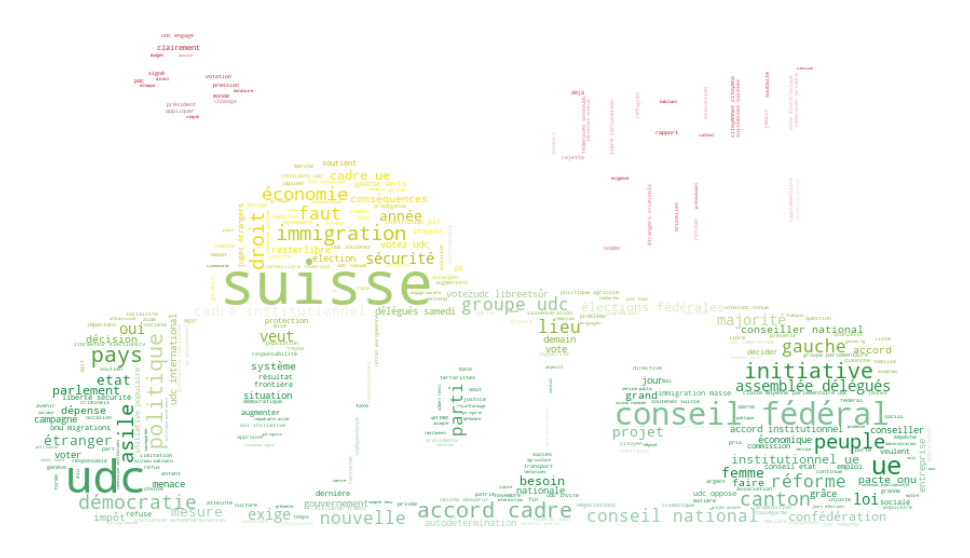

In [34]:
draw_wordcloud("data/logo/UDC_logo.gif", UDC_text)

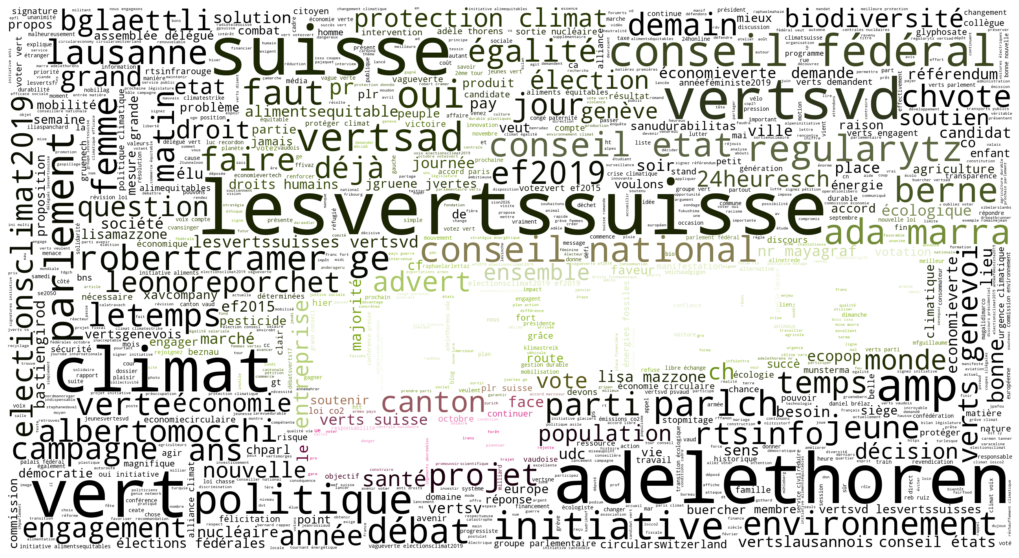

In [35]:
draw_wordcloud("data/logo/VERTS_logo.png", VERTS_text)

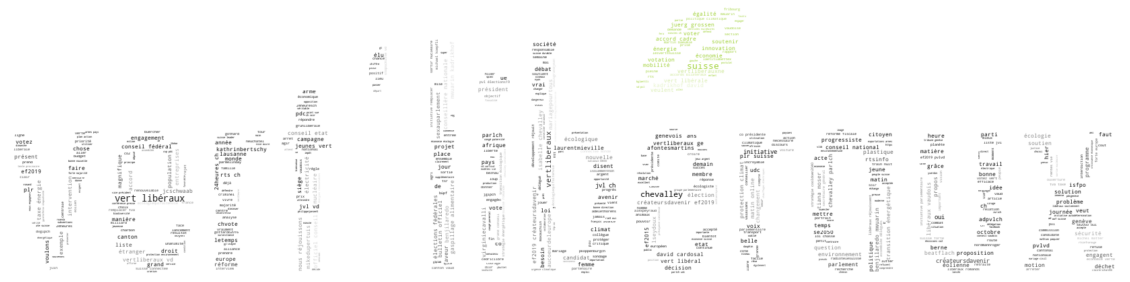

In [36]:
draw_wordcloud("data/logo/VERTS_LIB_logo.jpg", VERTS_LIB_text)

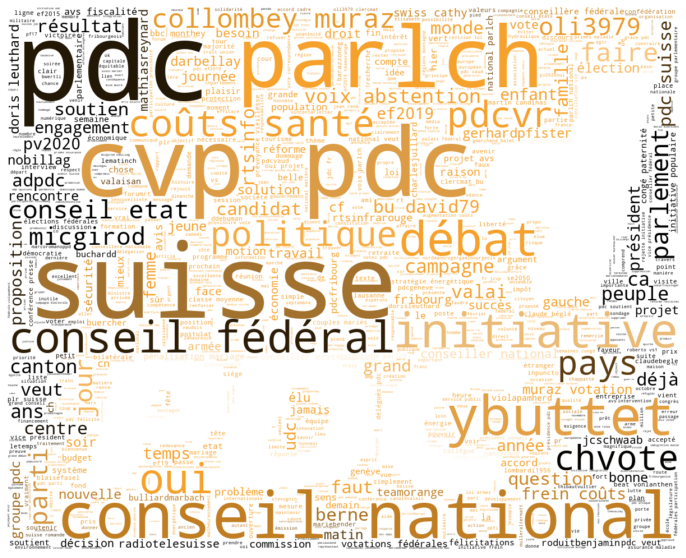

In [37]:
draw_wordcloud("data/logo/PDC_logo.png", PDC_text)

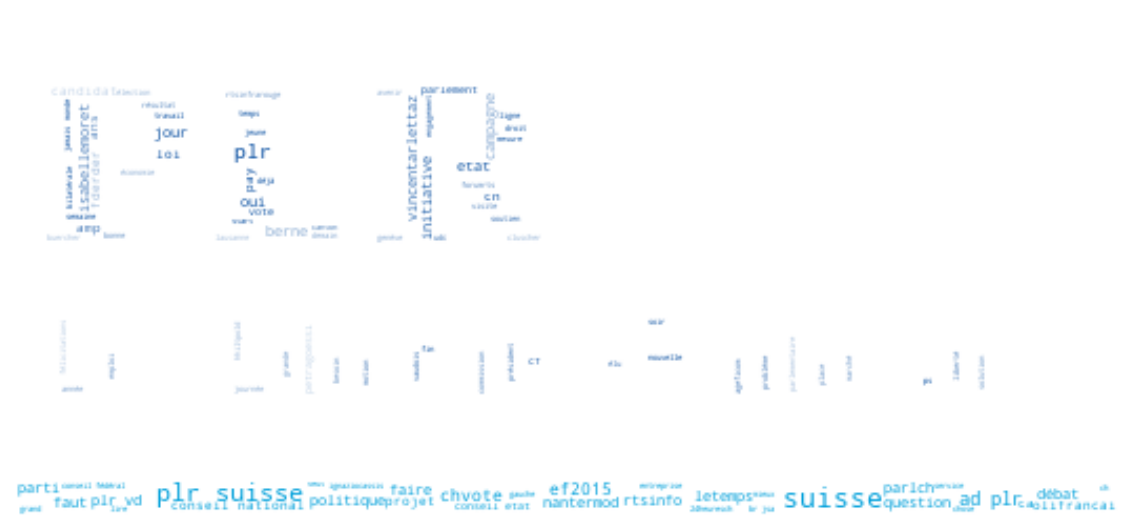

In [38]:
draw_wordcloud("data/logo/PLR_logo.png", PLR_text)

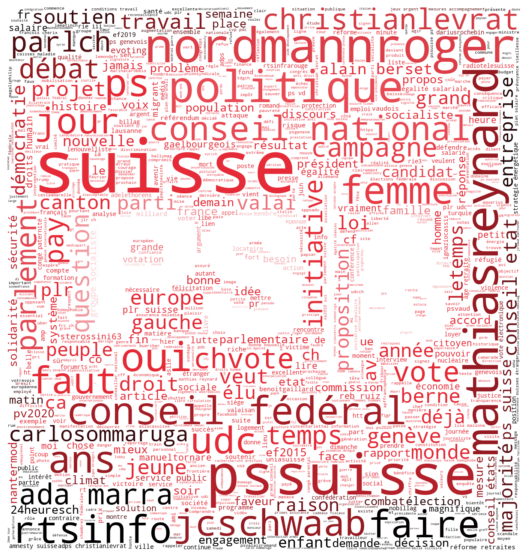

In [39]:
draw_wordcloud("data/logo/PS_logo.png", PS_text)

# Word2Vec


In [40]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [41]:
texts = [VERTS_text.split(" "), UDC_text.split(" "), PLR_text.split(" "), PDC_text.split(" "), VERTS_LIB_text.split(" "), PS_text.split(" ")]

In [42]:
keywords = topics_list_to_keyword(topics_list)

def text_to_list_keyword(text):
    mask = np.isin(text,keywords)
    array = np.array(text[:])
    return array[mask]

In [43]:
UDC_list_keyword = text_to_list_keyword(UDC_text.split(" "))
PS_list_keyword = text_to_list_keyword(PS_text.split(" "))
PLR_list_keyword = text_to_list_keyword(PLR_text.split(" "))
PDC_list_keyword = text_to_list_keyword(PDC_text.split(" "))
VERTS_list_keyword = text_to_list_keyword(VERTS_text.split(" "))
VERTS_LIB_list_keyword = text_to_list_keyword(VERTS_LIB_text.split(" "))

parties_list_keyword = [UDC_list_keyword, PS_list_keyword, PLR_list_keyword, PDC_list_keyword, VERTS_list_keyword, VERTS_LIB_list_keyword]

In [44]:
vector_size = 100
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
model = Doc2Vec(documents, vector_size=vector_size, window=10, min_count=1, workers=4)

In [45]:
def mean_list_word(list_word, model):
    mean = np.zeros(model.vector_size)
    for t in list_word:
        mean += model[t]
    return mean/len(list_word)

In [46]:
mean_UDC = mean_list_word(UDC_list_keyword, model)
mean_PS = mean_list_word(PS_list_keyword, model)
mean_PLR = mean_list_word(PLR_list_keyword, model)
mean_PDC = mean_list_word(PDC_list_keyword, model)
mean_VERTS = mean_list_word(VERTS_list_keyword, model)
mean_VERTS_LIB = mean_list_word(VERTS_LIB_list_keyword, model)

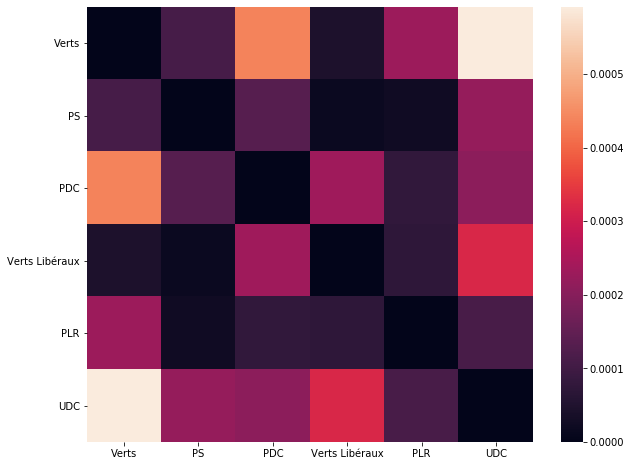

<Figure size 720x720 with 0 Axes>

In [47]:
means_parties = [mean_VERTS, mean_PS, mean_PDC, mean_VERTS_LIB, mean_PLR, mean_UDC]
parties = ["Verts", "PS", "PDC", "Verts Libéraux","PLR", "UDC"]

similiraties = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        similiraties[i][j] = spatial.distance.cosine(means_parties[i], means_parties[j])

fig, ax = plt.pyplot.subplots(figsize=(10,8)) 
sns.heatmap(similiraties, xticklabels=parties, yticklabels=parties, ax=ax)
plt.pyplot.figure(figsize=[10,10])
plt.pyplot.show()

In [50]:
def mean_list_word(list_keyword, model):
    mean = np.zeros(model.vector_size)
    for t in list_keyword:
        mean += model[t]
    return mean/len(list_keyword)

In [51]:
mean2_VERTS = mean_list_word(VERTS_text.split(" "), model)
mean2_UDC = mean_list_word(UDC_text.split(" "), model)
mean2_PS = mean_list_word(PS_text.split(" "), model)
mean2_PLR = mean_list_word(PLR_text.split(" "), model)
mean2_PDC = mean_list_word(PDC_text.split(" "), model)
mean2_VERTS_LIB = mean_list_word(VERTS_LIB_text.split(" "), model)

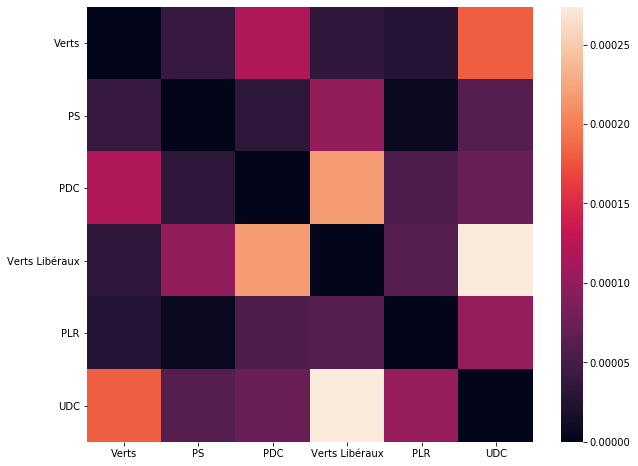

<Figure size 720x720 with 0 Axes>

In [52]:
means2_parties = [mean2_VERTS, mean2_PS, mean2_PDC, mean2_VERTS_LIB, mean2_PLR, mean2_UDC]
parties = ["Verts", "PS", "PDC", "Verts Libéraux","PLR", "UDC"]

similiraties2 = np.zeros((6,6))
for i in range(0,6):
    for j in range(0,6):
        similiraties2[i][j] = spatial.distance.cosine(means2_parties[i], means2_parties[j])
        
fig, ax = plt.pyplot.subplots(figsize=(10,8)) 
sns.heatmap(similiraties2, xticklabels=parties, yticklabels=parties, ax=ax)
plt.pyplot.figure(figsize=[10,10])
plt.pyplot.show()

# Use a dictionary

In [53]:
french_words = pd.read_csv("data/frenchwords", header=None)

In [54]:
french_words = np.array(french_words.values.tolist()).flatten()